In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt 
from thermal.utils import calc_diffusivity
from thermal.plotting import (enthalpy_pcolormesh, 
                              EnthalpyNormalizer, 
                              custom_diverging)
from thermal.derived_fields import calc_length, calc_mean_enthalpy

plt.rcParams.update({'font.size': 12, 
                     'text.usetex': True})

In [ ]:
src_fp = '/Volumes/thermal_ssd/crmpt12/thinned/crmpt12_dx_50_NT_30000_dt_0.1_MB_-0.37_OFF_Tma_-8.5_prog.zarr'
# lazy load the zarr file
src = xr.open_zarr(src_fp)
# drop the parameter dims for this purpose
src = src.squeeze().interp(coord_2=np.linspace(0,15,101))

In [ ]:
# constant temperate ice diffusivity [J a-1 m-2]
kappa_0 = 3.295e3 
# temperature and density depndent cold ice diffusivity [J a-1 m-2]
kappa_c = calc_diffusivity(src.temperature, src.densi)
# select the correct diffusvity 
kappa   = xr.where(src.enthalpy_h >= src['phase change enthalpy'], 
                   kappa_0, kappa_c)

In [ ]:
dz = np.diff(src.Z.isel(t=-1), axis=0)
dz = np.vstack((dz, dz[-1,:]))

Pe_x = (np.abs(src.vel_x.isel(t=-3)) * 50) / (kappa.isel(t=-3) * 1/src.densi.isel(t=-3))
Pe_z = (np.abs(src.vel_z.isel(t=-3)) * dz) / (kappa.isel(t=-3) * 1/src.densi.isel(t=-3))

In [ ]:
norm = EnthalpyNormalizer(0.0, 300, vcenter=1.0, ncenter=2/5)
cmap = custom_diverging(norm, cold='Blues', warm='Oranges')

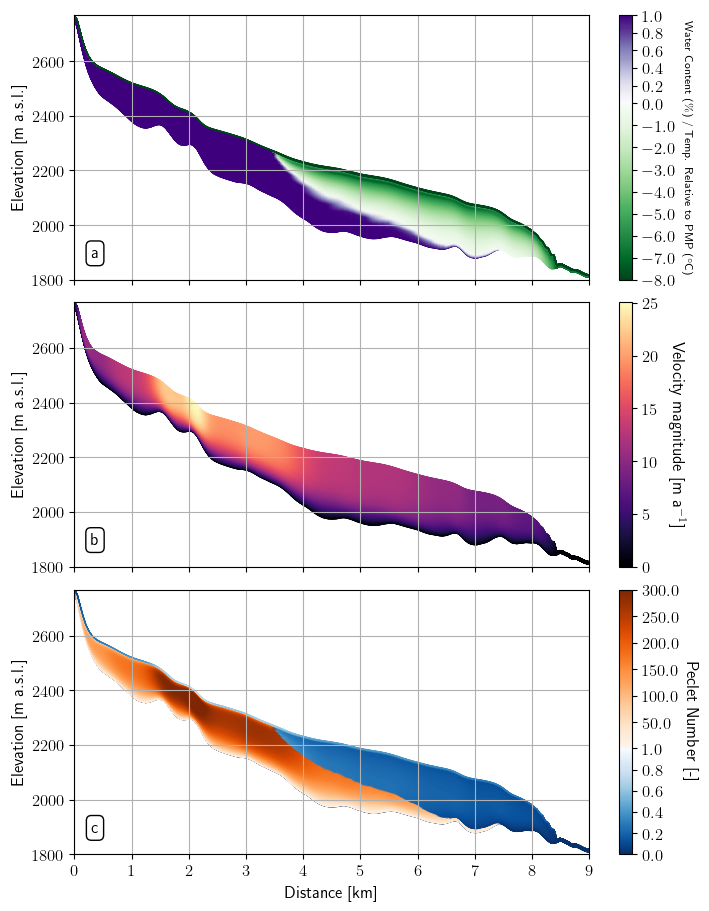

In [14]:
fig, ax = plt.subplots(3,1, sharex=True, sharey=True, 
                       constrained_layout=True, 
                       figsize=(7, 9))
    
enth = enthalpy_pcolormesh(src, -1, axes=ax[0], W_max=1.0, rasterized=True)

vel  = ax[1].pcolormesh(src.X[:,::-1]/1e3, 
                        src.Z.isel(t=-1), 
                        src.vel_m.isel(t=-1), 
                        cmap='magma',
                        shading='gouraud', 
                        rasterized=True)


Peclet = ax[2].pcolormesh(src.X[:,::-1]/1e3, 
                        src.Z.isel(t=-1), 
                        (Pe_x**2 + Pe_z**2)**(1/2), 
                        # levels=np.concatenate((np.linspace(0,1,21), np.linspace(50, 300, 26))), 
                        norm=norm, cmap=cmap, shading='gouraud',
                        rasterized=True)
                        # linestyles='None', 
                        # extend='max')
                          
cbar = fig.colorbar(enth,  ax=ax[0])
cbar.set_ticks(np.concatenate((np.linspace(-8, 0, 9), np.linspace(0.2, 1.0, 5))))
cbar.set_label(r'Water Content ($\%$) / Temp. Relative to PMP ($^\circ$C)',
               fontsize=8,
               # fontsize='small',
               rotation=270, labelpad=12.5)

cbar = fig.colorbar(vel,   ax=ax[1])
cbar.set_label('Velocity magnitude [m a$^{-1}$]', rotation=270, labelpad=20)

cbar = fig.colorbar(Peclet,ax=ax[2])
cbar.set_ticks(np.concatenate((np.linspace(0, 1.0, 6), np.linspace(50, 300, 6))))
cbar.set_label('Peclet Number [-]', rotation=270, labelpad=15)

  
labels = ['a', 'b', 'c']

for i, axes in enumerate(ax):
    axes.set_ylabel('Elevation [m a.s.l.]')
    
    
    axes.text(0.04, 0.1,  labels[i], 
              ha='center', va='center', transform=axes.transAxes, 
              bbox=dict(boxstyle="round", fc='w') )
        
    axes.grid(zorder=-1)
    
ax[2].set_xlabel('Distance [km]')

ax[2].set_xlim(0, 9)
ax[2].set_ylim(1800, None)

fig.savefig('../figs/crmpt12/reference_distributed.pdf', dpi=400)
fig.savefig('../figs/crmpt12/reference_distributed.png', dpi=400)

In [ ]:
H = src.height.isel(t=-1, coord_2=-1).compute()

print(f'Mean ice thickness : {float(H.mean()):.1f} (m)')
print(f'Max  ice thickness : {float(H.max()):.1f} (m)')

Mean ice thickness : 122.8 (m)
Max  ice thickness : 238.9 (m)


# Reference Timeseries Values

In [51]:
# compute the average fraction temperate over the last year of the simulation
FT = src.percent_temperate.compute() / 100
FT_final = FT.isel(t=slice(-10,None)).mean()

# compute the average mean enthalpy over the last year of the simulation
H_final = calc_mean_enthalpy(src.isel(t=slice(-10,None)).compute()).mean() / 1e3

print(f'Final fraction temperate : {float(FT_final):.4f} (-)')
print(f'Final    mean enthalpy   : {float(H_final):.2f} (kJ/kg)')

Final fraction temperate : 0.5472 (-)
Final    mean enthalpy   : 133.27 (kJ/kg)


# ELA / AAR

In [57]:
# calculate the S.S. length 
L = calc_length(src.isel(t=[-1]))

# the difference of the sign will tell us where the mass balance crosses zero
mask = xr.apply_ufunc(np.diff, 
                      np.sign(src['mass balance'].isel(t=-1)), 
                      kwargs={"axis": -1, "prepend" : -1},
                      dask="allowed")

# since coord_1 is an int, make sure we reutrn an int as well
ELA_idx = src.coord_1.where(mask == 2, drop=True).astype(int).values[0]
# calculate the actual ELA 
ELA = src.Z.isel(t=-1, coord_2=-1).sel(coord_1=ELA_idx)
# find the postion [km] along the flowline of the ELA 
L_ela = src.X.isel(coord_2=-1)[::-1].sel(coord_1=ELA_idx) / 1e3
# calculate the accumulation area ratio for the S.S. glacier
AAR = L_ela / L 

print(f'ELA @ {float(ELA):.1f} (m a.s.l.)')
print(f'AAR : {float(AAR):.3f} (-)')

ELA @ 2275.1 (m a.s.l.)
AAR : 0.406 (-)


# Seasonal Layer

This is probably way fancier than it needs to be.... 

In [58]:
# the difference of the sign will tell us where the mass balance crosses zero
mask = xr.apply_ufunc(np.diff, 
                      np.sign(src.X.isel(coord_2=-1)[::-1] - float(L)*1e3), 
                      kwargs={"axis": -1, "prepend" : 1},
                      dask="allowed")

L_idx = src.coord_1.where(mask == -1, drop=True).astype(int).values

if L_idx.size > 1: 
    L_idx = L_idx[-1]

In [100]:
# empty dataset to store 
cold_ice = xr.Dataset()
# select subset of variables from ELA to terminus
cold_ice['depth'] = src.depth.isel(t=-1).sel(coord_1=slice(L_idx+1, ELA_idx-1))
cold_ice['temp' ] = src.temperature.isel(t=slice(-10,None)).sel(coord_1=slice(L_idx+1, ELA_idx-1))
# load into memory
cold_ice = cold_ice.persist()

In [72]:
# depth which standard deviation in temp doesn't exceed threshold
def find_depth(src): 
    return src.depth.where(src.temp.std('t') < 5e-2, drop=True).isel(coord_2=-1)
# apply function and 
seasonal_layer = cold_ice.groupby('coord_1').apply(find_depth).compute()

Text(0.5, 0, 'Temperature ($^\\circ$C)')

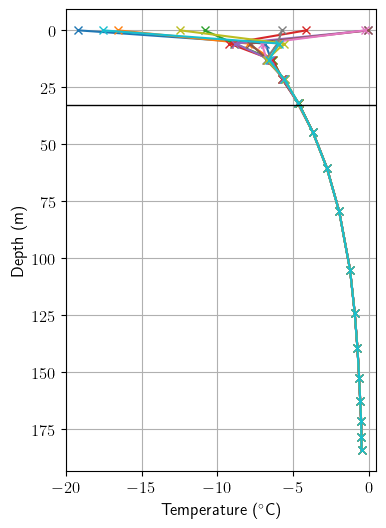

In [104]:
# compute the average temperatre profile below the ELA for the 10 final timesteps
average = cold_ice.mean('coord_1')

fig, ax = plt.subplots(figsize=(4,6))

for t in average.t: 
    ax.plot(average.temp.sel(t=t), average.depth, marker='x')

ax.axhline(seasonal_layer.mean(), c='k', lw=1.0)

ax.invert_yaxis()
ax.grid()
ax.set_xlim(-20,0.5)
# ax.set_ylim(100,-5)

ax.set_ylabel('Depth (m)')
ax.set_xlabel('Temperature ($^\circ$C)')

# Average Surface Element Height 

In [110]:
# filter out passive ice where dz will always be 1.0
dz = (src.Z.isel(t=-1, coord_2=-1) - src.Z.isel(t=-1, coord_2=-2)).where(lambda x: x>1).mean().compute()

print(f'Average Surface Element Height : {float(dz.mean()):.2f} (m)')

Average Surface Element Height : 5.13 (m)
